In [4]:
from mindspore import ops
from mindspore.common import dtype as mstype
import mindspore as ms
from mindspore import nn
from mindspore.nn import LossBase
from mindspore import context


In [2]:
import numpy as np
from glob import glob
import os
import nibabel as nib
import cv2
from matplotlib import pyplot as PLT
from scipy import sparse
from tqdm import tqdm

In [3]:
def GetBodyArea(ct, padding=5):
    cs, ch, cw = ct.shape
    src = np.zeros([3, ch, cw])
    src[0, :, :] = ct[cs // 4 * 1, :, :]
    src[1, :, :] = ct[cs // 4 * 2, :, :]
    src[2:, :] = ct[cs // 4 * 3, :, :]
    src = src.max(axis=0)
    src = (src - src.min()) * 255 / (src.max() - src.min())
    src = np.uint8(src)

    _, src = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    src = cv2.morphologyEx(src, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    cnts, hu = cv2.findContours(src, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return 0, 0, cw, ch
    max_area = 0
    max_cnt = cnts[0]
    for c in cnts:
        area = cv2.contourArea(c)
        if max_area < area:
            max_area = area
            max_cnt = c
    if max_area < cw * ch / 4:
        return 0, 0, cw, ch
    x, y, w, h = cv2.boundingRect(max_cnt)
    w = w + padding if x + w + padding < cw else cw - x
    h = h + padding if x + h + padding < ch else ch - x
    x = x - padding if x > padding else 0
    y = y - padding if y > padding else 0

    return x, y, w, h


def cvresize(src, size):
    minc = min(size)
    s = src.shape[-1] // minc
    if s != 0 and src.shape[-1] != minc:
        dst = np.zeros((size[1], size[0], src.shape[-1]))
        for i in range(s + 1):
            if i != s:
                dst[:, :, i * minc : (i + 1) * minc] = cv2.resize(
                    src[:, :, i * minc : (i + 1) * minc], size
                )
            else:
                dst[:, :, i * minc :] = cv2.resize(src[:, :, i * minc :], size)
    else:
        dst = cv2.resize(src, size)
    return dst


def ReSp(src, x, y, w, h, restore=False, size=512):
    if restore:
        dst = np.zeros((src.shape[0], size, size), np.float64)
        src = src.transpose((1, 2, 0))
        src = cvresize(src, [w, h])
        src = src.transpose((2, 0, 1))
        dst[:, y : y + h, x : x + w] = src
    else:
        dst = src[:, y : y + h, x : x + w]
        dst = dst.transpose((1, 2, 0))
        dst = cvresize(dst, [size, size])
        dst = dst.transpose((2, 0, 1))
    return dst

100%|██████████| 210/210 [34:29<00:00,  9.85s/it]


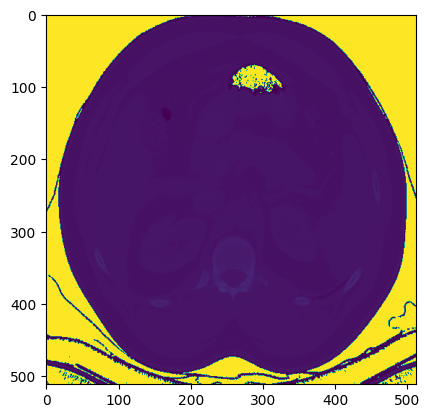

In [80]:
pad = 10
save_path = '/home/cat/lrx/git/kits19/train'
path = '/home/cat/lrx/git/kits19/data'
# cts = glob(os.path.join(path,'case_*/imaging.nii.gz'))
segs = glob(os.path.join(path,'case_*/segmentation.nii.gz'))
segs = sorted(segs)

for seg_path in tqdm(segs):
    ct_path = os.path.join(os.path.dirname(seg_path),'imaging.nii.gz')
    name = ct_path.split('/')[-2]
    ct = nib.load(ct_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()
    assert ct.shape == seg.shape
    x, y, w, h = GetBodyArea(ct)
    ct = ReSp(ct, x, y, w, h)
    seg = ReSp(seg, x, y, w, h)
    # ct = (ct-ct.min()) / (ct.max()-ct.min()) * 1024
    ct_norm = (ct-ct.mean())/ct.std() * 255
    # print(ct_norm.min(),ct_norm.max())
    ct = ct_norm - ct_norm.min() - 1/ct.std()*255*100
    ct = np.float32(ct)
    seg = np.int8(seg)
    z = np.any(seg,axis=(1, 2))
    z = np.where(z)[0]
    begin = max(pad+1, z[0])
    end = min(seg.shape[0]-pad, z[-1])
    ct = ct[begin:end,:,:]
    seg = seg[begin:end,:,:]
    if ct.std(axis=(1,2)).std()>25:
        continue

    PLT.imshow(ctshow[5])
    try:
        os.makedirs(os.path.join(save_path,name))
    except:
        pass
    ctshow=ct
    ctshow[ctshow<0] = 1000
    PLT.imshow(ctshow[5])
    PLT.savefig(os.path.join(save_path,'img',name+'.jpg'))
    np.save(os.path.join(save_path,name,'ct.npy'), ct)
    seg_sp = np.array([sparse.csc_matrix(seg[i,:,:]) for i in range(seg.shape[0])])
    np.save(os.path.join(save_path,name,'seg.npy'), seg_sp)

# np.load('case_00115_seg.npy')

In [1]:
import numpy as np

a = np.zeros((5,3))
b = np.array([0,1,2,0,2])
a[b==1]=np.array([0, 255, 0])
a[b==2]=np.array([0, 0, 255])
print(a)

[[  0.   0.   0.]
 [  0. 255.   0.]
 [  0.   0. 255.]
 [  0.   0.   0.]
 [  0.   0. 255.]]
